<h1 style="display: flex; align-items: center;">
    <img src="https://github.com/nivbartov/MRI_Brain_Alzheimer_Classification/blob/main/assets/icons/deep-learning.png?raw=1" style="width: 50px; height: 50px; margin-right: 10px;">
    <strong>MRI Brain Alzheimer Classification - ResNet Model with Adversarial Attacks</strong>
</h1>

****

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-git-48.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Clone Repository from GitHub
</h1>

In [1]:
# Clone repository from GitHub
# !git clone https://github.com/nivbartov/MRI_Brain_Alzheimer_Classification

# %cd MRI_Brain_Alzheimer_Classification
%cd ..

c:\Dor\TECHNION\deep_learning\Project\MRI_Brain_Alzheimer_Classification


<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-import-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Import Packages
</h1>

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
import sys
import os
import numpy as np
import pandas as pd
import torch
from torchsummary import summary
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Subset, ConcatDataset
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from kornia import augmentation as K
from kornia.augmentation import AugmentationSequential
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import random
import time
from datetime import datetime
import json
import gc
import subprocess

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-function-80.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Import Internal Functions
</h1>

In [3]:
from models import def_models
from utils import utils_funcs
from utils import optuna_search

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-gpu-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Define Definition
</h1>

In [4]:
print(f'torch.cuda.is_available(): {torch.cuda.is_available()}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')
torch.cuda.empty_cache()
gc.collect()
utils_funcs.open_nvitop()

torch.cuda.is_available(): True
device: cuda:0


<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-load-50.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Load Dataset
</h1>

In [5]:
train_set = torch.load('dataset/dataset_variables/train_set.pt')
validation_set = torch.load('dataset/dataset_variables/validation_set.pt')
test_set = torch.load('dataset/dataset_variables/test_set.pt')

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-data-recovery-40.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Model Definition and Initialization
</h1>

In [6]:
# Initialize input and output sizes
input_width = 224
input_height = 224
input_channels = 3
output_channels = 4

# Load a pre-trained ResNet34 model
ResNet_backbone_model = torchvision.models.resnet34(pretrained=True)

# Finetune EfficientNet-B0 layers
for param in ResNet_backbone_model.parameters():
    param.requires_grad = True

# Create ResNet34 model with FC layers before the output
model = def_models.ResNet(ResNet_backbone=ResNet_backbone_model, output_channels=output_channels).to(device)

**Load Trained Model**

In [13]:
# retrieve the fined-tuned model
model_path = './checkpoints/ResNet_094701_19102024/ResNet_102831_19102024_train_0.0098_val_0.0427.pth'
checkpoint = torch.load(model_path,weights_only=True)
model.load_state_dict(checkpoint['net'])

<All keys matched successfully>

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-statistics-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Model statistics
</h1>

In [8]:
model_name = type(model).__name__ + '_atk'
print("Model", model_name, "statistics:")
summary(model, (input_channels, input_height, input_width))

Model ResNet_atk statistics:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
          

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-tuna-50.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Set Hyper-Parameters Using Optuna
</h1>

In [9]:
load_existing_hyperparams = True

if load_existing_hyperparams:
    # Load hyper-parameters (relevant if optuna has already used)
    optuna_params_path = f"./checkpoints/optuna_params/Resnet/ResNet_0.9000.json"
    with open(optuna_params_path, 'r') as file:
        hyperparams = json.load(file)
else:
    # Find optimal hyper-parameters using optuna
    torch.cuda.empty_cache()
    hyperparams = optuna_search.optuna_param_search(model_name="EfficientNet", loss_criterion=nn.CrossEntropyLoss(), num_epochs_for_experiments=10, device=device, transfer_learning=True)

print(hyperparams)

{'lr': 0.00013260296994192767, 'optimizer': 'Adam', 'batch_size': 32, 'scheduler': 'CosineAnnealingLR'}


In [10]:
# Set hyper-parameters
batch_size = hyperparams['batch_size']
learning_rate = hyperparams['lr']
optimizer_name = hyperparams['optimizer']
optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=learning_rate)

num_epochs = 25
scheduler_name = hyperparams['scheduler']

# Set up the learning rate scheduler based on the chosen scheduler
if scheduler_name == "StepLR":
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
elif scheduler_name == "CosineAnnealingLR":
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, verbose=True)
elif scheduler_name == "ReduceLROnPlateau":
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)
else:
    raise ValueError(f"Unknown scheduler: {scheduler_name}")

criterion = nn.CrossEntropyLoss()

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-loader-80.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Create Data Loaders
</h1>

In [11]:
# Test loader witch batch size of 1 (in order to perform attacks one by one)
testloader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True, num_workers=6, pin_memory=True)

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-knife-64.png" style="width: 50px; height: 50px; margin-right: 5px;">
    Perform Fast Gradient Sign (FGSM) Attack
</h1>

In [12]:
accuracies = []
examples = []
epsilons = [0, .0005, .005, .05, .1, .15, .2, .25, .3]
for eps in epsilons:
    print(f"Performing attack using epsilon {eps}")
    acc, ex = utils_funcs.test_single_point_attack(model, device, testloader, 'fgsm', eps)
    accuracies.append(acc)
    examples.append(ex)
    print(f"The accuracy is: {acc}%")

utils_funcs.print_accuracy_table(epsilons, accuracies, parameter_type ='Epsilon')

Performing attack using epsilon 0
The accuracy is: 87.17748240813135
Performing attack using epsilon 0.0005


KeyboardInterrupt: 

In [13]:
utils_funcs.plot_adversarial_examples(epsilons, examples, attack_name='FGSM', parameter_type = 'Epsilon')

<Figure size 2300x1400 with 0 Axes>

: 

: 

: 

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-weapon-48.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Perform Projected Gradient Descent (PGD) Attack
</h1>

In [14]:
accuracies = []
examples = []
epsilon = 0.005
num_iter = 5
alphas = [0, 0.001, 0.0001, 0.0008, 0.00001, 0.00004]


for alpha in alphas:
    print(f"Performing attack using alpha {alpha}")
    acc, ex = utils_funcs.test_single_point_attack(model, device, testloader, 'pgd', epsilon, alpha=alpha, num_iter=num_iter)
    accuracies.append(acc)
    examples.append(ex)
    torch.cuda.empty_cache()
    gc.collect()

utils_funcs.print_accuracy_table(alphas, accuracies, parameter_type ='Alpha')

Performing attack using alpha 0


KeyboardInterrupt: 

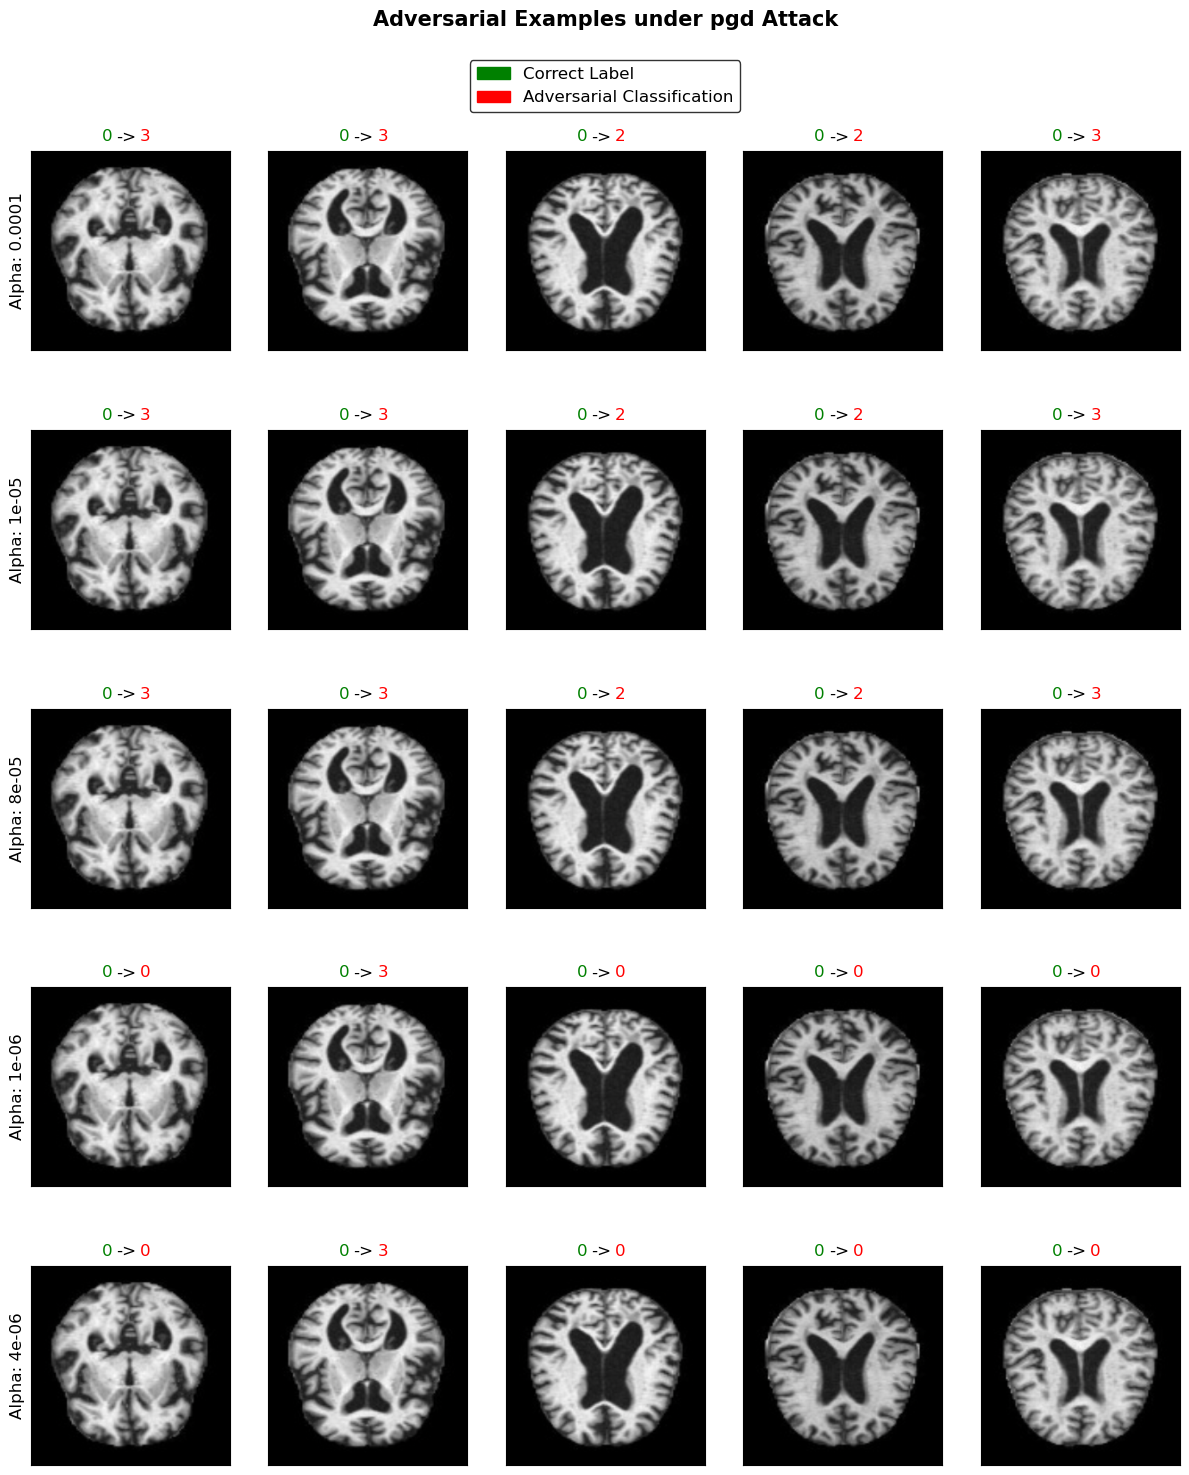

In [16]:
utils_funcs.plot_adversarial_examples(alphas, examples , attack_name='PGD', parameter_type = 'Alpha')

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-augmentation-64.png" style="width: 40px; height: 40px; margin-right: 5px;">
    Data Augmentations
</h1>

In [12]:
augmentations = K.AugmentationSequential(
    K.RandomHorizontalFlip(p=0.1),
    K.RandomVerticalFlip(p=0.1),
    K.RandomRotation(degrees=10, p=0.1),
    K.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05), p=0.1),
    K.RandomBrightness(brightness=(0.8, 1.2), p=0.1),
    K.RandomContrast(contrast=(0.8, 1.2), p=0.1),
    K.RandomGamma(gamma=(0.9, 1.1), p=0.1),
    K.RandomSharpness(p=0.1),
    same_on_batch=False
)

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-training-100.png" style="width: 50px; height: 50px; margin-right: 5px;">
    Adversarial Training
</h1>

In [13]:
# Set hyper-parameters
num_epochs = 25
train_epsilon = epsilon = 0.005
alpha = 0.01
adv_weight = 0.20
num_iter = 5

# Data loading and shuffling
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
validationloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [14]:
load_existing_params = True
train_loaded_model = False

if load_existing_params:
    model_path = './checkpoints/EfficientNet_atk_070449_18102024/EfficientNet_atk_083159_18102024_train_0.2527_val_1.8675.pth'
    checkpoint = torch.load(model_path, weights_only=True)
    model.load_state_dict(checkpoint['net'])
        
    if(train_loaded_model):
        epoch_train_losses, epoch_validation_losses, epoch_train_accuracies, epoch_validation_accuracies =  utils_funcs.adversarial_train_model(model, num_epochs, trainloader, validationloader, device, criterion, optimizer,'pgd', epsilon = epsilon, adv_weight = adv_weight,
                                                                                                                                           alpha = alpha,num_iter=num_iter, kornia_aug=augmentations, use_amp=True, scheduler=scheduler) 
    else:
        # Load the saved values from the checkpoint
        epoch_train_losses = checkpoint['train_epoch_losses']
        epoch_validation_losses = checkpoint['validation_epoch_losses']
        epoch_train_accuracies = checkpoint['train_epoch_accuracies']
        epoch_validation_accuracies = checkpoint['validation_epoch_accuracies']      
        num_epochs = checkpoint['epoch'] 
        
else:    
    epoch_train_losses, epoch_validation_losses, epoch_train_accuracies, epoch_validation_accuracies = utils_funcs.adversarial_train_model(model, num_epochs, trainloader, validationloader, device, criterion, optimizer,'pgd', epsilon = epsilon, adv_weight = adv_weight,
                                                                                                                                           alpha = alpha,num_iter=num_iter, kornia_aug=augmentations, use_amp=True, scheduler=scheduler)                                                                                                                    

<h1 style="display: flex; align-items: center; font-size: 25px; margin: 0;">
    <img src="../assets/icons/icons8-results-58.png" style="width: 50px; height: 50px; margin-right: 5px;">
    Results
</h1>

In [ ]:
test_accuracy = utils_funcs.calculate_accuracy(model, testloader, device)
print("Test accuracy on regular test set: {:.3f}%".format(test_accuracy))

test_accuracy_adversial_attk = utils_funcs.calculate_accuracy_attack(model, testloader,device,attack_type='fgsm',epsilon=train_epsilon)
print("Test accuracy on adversial attacks using FGSM method: {:.3f}%".format(test_accuracy_adversial_attk))

test_accuracy_adversial_attk = utils_funcs.calculate_accuracy_attack(model, testloader,device,attack_type='pgd',epsilon=train_epsilon, alpha=alpha, num_iter=num_iter)
print("Test accuracy on adversial attacks using PGD method: {:.3f}%".format(test_accuracy_adversial_attk))

Test accuracy on regular test set: 96.951%
Test accuracy on adversial attacks using FGSM method: 36.591%


<Figure size 800x600 with 0 Axes>

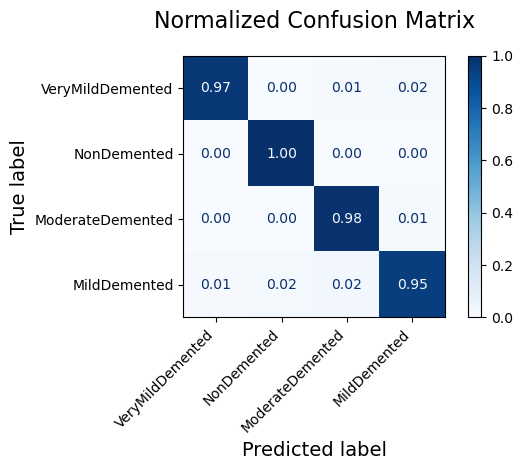

In [15]:
class_names = ['VeryMildDemented', 'NonDemented', 'ModerateDemented', 'MildDemented']
utils_funcs.plot_normalized_confusion_matrix(testloader, model, class_names, device, model_name)

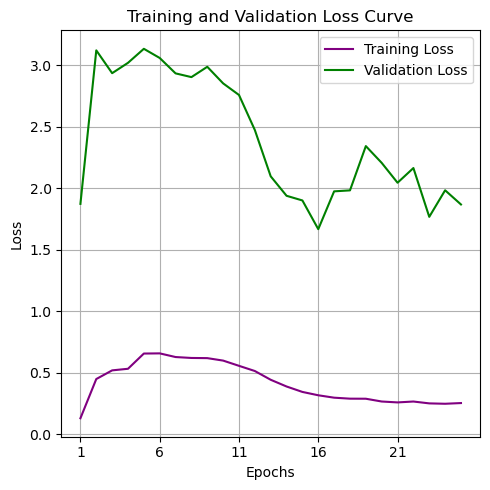

In [16]:
utils_funcs.plot_loss_curve(epoch_train_losses, epoch_validation_losses, num_epochs, model_name)

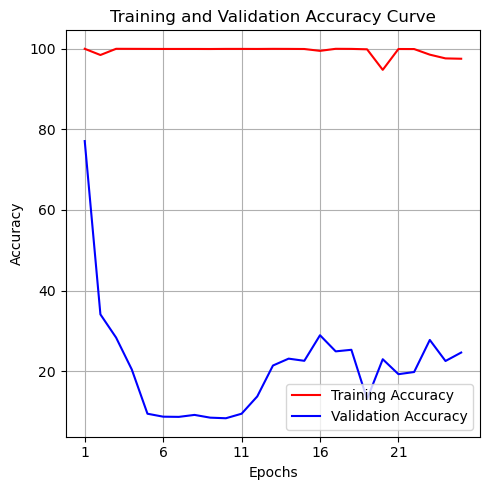

In [17]:
utils_funcs.plot_accuracy_curve(epoch_train_accuracies, epoch_validation_accuracies, num_epochs, model_name)